# Importing Libraries

In [1]:
#pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, fbeta_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Load Datasets

In [3]:
test_data = pd.read_csv(r"D:\PDFs\Edvancer Eduventures\Certified Machine Learning Expert\Projects\Marketing\carvan_test.csv") 
train_data = pd.read_csv(r"D:\PDFs\Edvancer Eduventures\Certified Machine Learning Expert\Projects\Marketing\carvan_train.csv")

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 86 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   V1      5822 non-null   int64
 1   V2      5822 non-null   int64
 2   V3      5822 non-null   int64
 3   V4      5822 non-null   int64
 4   V5      5822 non-null   int64
 5   V6      5822 non-null   int64
 6   V7      5822 non-null   int64
 7   V8      5822 non-null   int64
 8   V9      5822 non-null   int64
 9   V10     5822 non-null   int64
 10  V11     5822 non-null   int64
 11  V12     5822 non-null   int64
 12  V13     5822 non-null   int64
 13  V14     5822 non-null   int64
 14  V15     5822 non-null   int64
 15  V16     5822 non-null   int64
 16  V17     5822 non-null   int64
 17  V18     5822 non-null   int64
 18  V19     5822 non-null   int64
 19  V20     5822 non-null   int64
 20  V21     5822 non-null   int64
 21  V22     5822 non-null   int64
 22  V23     5822 non-null   int64
 23  V24     5822 

In [5]:
train_data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
5,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0
6,39,2,3,2,9,2,2,0,5,7,...,0,0,0,0,0,0,0,0,0,0
7,33,1,2,3,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0
8,33,1,2,4,8,0,1,3,6,6,...,0,0,0,0,0,0,0,0,0,0
9,11,2,3,3,3,3,5,0,2,7,...,0,0,0,1,0,0,0,0,0,0


# Data Preprocessing

In [6]:
X = train_data.drop(columns=['V86'])

In [7]:
y = train_data['V86']

# Handling Missing Values

In [8]:
imputer = SimpleImputer(strategy='mean')

In [9]:
X = imputer.fit_transform(X)

In [10]:
test_data = imputer.transform(test_data)

# Feature Scaling

In [11]:
scaler = StandardScaler()

In [12]:
X = scaler.fit_transform(X)

In [13]:
test_data = scaler.transform(test_data) 

In [14]:
test_data

array([[ 0.68090623, -0.27257995,  1.67289335, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [-1.42098041, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 1.14799215, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       ...,
       [ 0.91444919, -0.27257995, -0.85950007, ..., -0.15062046,
        10.96783552, -0.11881647],
       [ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [-1.26528511, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647]])

# Handle Imbalanced Dataset using SMOTE

In [15]:
smote = SMOTE(random_state=42)

In [16]:
X_res, y_res = smote.fit_resample(X, y)

# Train-Test Split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Applying Random Trees Algorithm

In [18]:
rf_model = RandomForestClassifier(random_state=42) 

In [19]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [20]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2) 

In [21]:
grid_search.fit(X_train, y_train) 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [22]:
best_rf_model = grid_search.best_estimator_ 

In [23]:
y_val_pred_proba = best_rf_model.predict_proba(X_val)[:, 1]

In [24]:
threshold = 0.3
y_val_pred = (y_val_pred_proba >= threshold).astype(int)

In [25]:
thresholds = np.arange(0.1, 0.9, 0.05)

# Initialize lists to store metrics

In [26]:
accuracy_scores = []
f1_scores = []
fbeta_scores = []
roc_auc_scores = []

In [27]:
for threshold in thresholds:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)

    
    accuracy = accuracy_score(y_val, y_val_pred)
    f1 = fbeta_score(y_val, y_val_pred, beta=1, zero_division=0)
    fbeta = fbeta_score(y_val, y_val_pred, beta=2, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    
    # Append metrics to respective lists
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    fbeta_scores.append(fbeta)
    roc_auc_scores.append(roc_auc)


optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]

In [28]:
print(f"Optimal Threshold (based on F1-score): {optimal_threshold}")
print(f"Validation Accuracy at Optimal Threshold: {accuracy_scores[optimal_threshold_index]}")
print(f"Validation F1-score at Optimal Threshold: {f1_scores[optimal_threshold_index]}")
print(f"Validation ROC AUC Score at Optimal Threshold: {roc_auc_scores[optimal_threshold_index]}")
print(f"Validation F-beta Score (beta=0.5) at Optimal Threshold: {fbeta_scores[optimal_threshold_index]}")

Optimal Threshold (based on F1-score): 0.5500000000000002
Validation Accuracy at Optimal Threshold: 0.9593607305936073
Validation F1-score at Optimal Threshold: 0.9580386610089581
Validation ROC AUC Score at Optimal Threshold: 0.9869753889198003
Validation F-beta Score (beta=0.5) at Optimal Threshold: 0.9481149682717432


In [29]:
y_test_pred_proba = best_rf_model.predict_proba(test_data)[:, 1]

In [30]:
y_test_pred = (y_test_pred_proba >= optimal_threshold).astype(int)

In [31]:
submission = pd.DataFrame({'V86': y_test_pred})
submission.to_csv('submission.csv', index=False)

# Class Distribution Before and After SMOTE

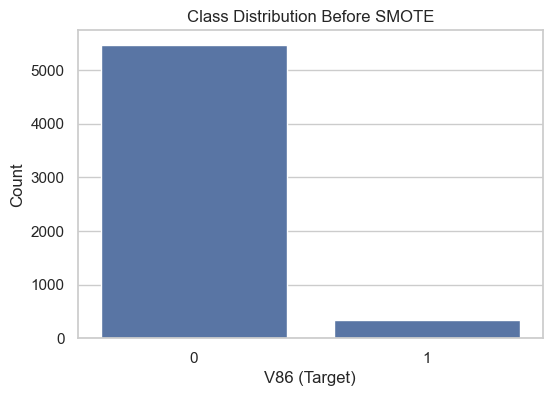

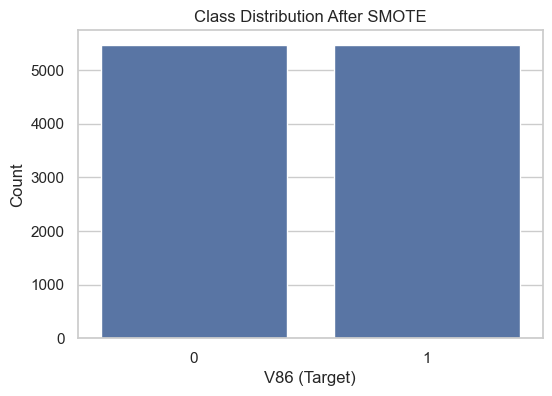

In [32]:
# Before SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('V86 (Target)')
plt.ylabel('Count')
plt.show()

# After SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res)
plt.title('Class Distribution After SMOTE')
plt.xlabel('V86 (Target)')
plt.ylabel('Count')
plt.show()

# Feature Correlation Heatmap

In [33]:
X_df = pd.DataFrame(X, columns=[f'V{i}' for i in range(1, 86)])

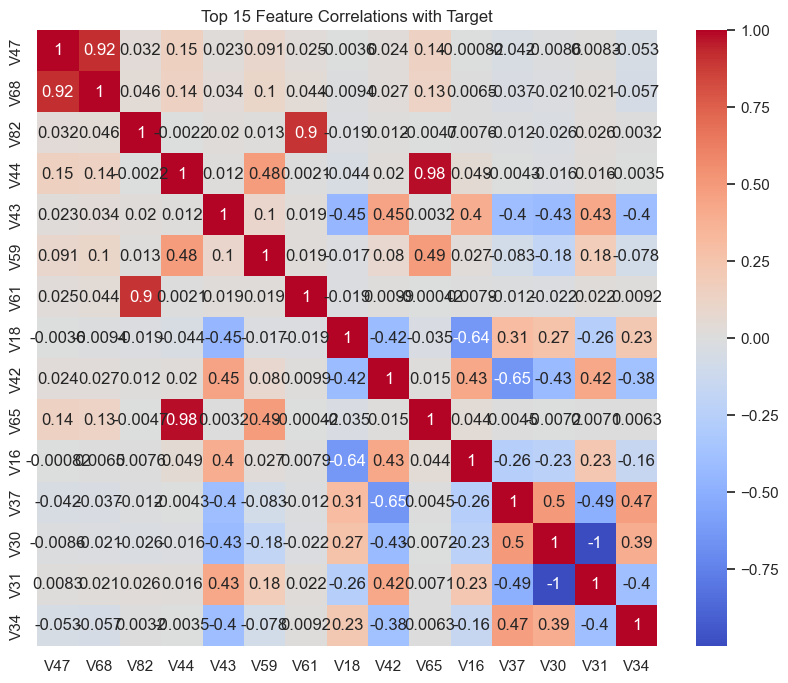

In [34]:
# Plot correlation heatmap of top 15 correlated features with target
corr_matrix = pd.concat([X_df, y.reset_index(drop=True)], axis=1).corr()
top_corr_features = corr_matrix['V86'].abs().sort_values(ascending=False)[1:16].index

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features], annot=True, cmap='coolwarm')
plt.title("Top 15 Feature Correlations with Target")
plt.show()

# Threshold vs Metrics Curve

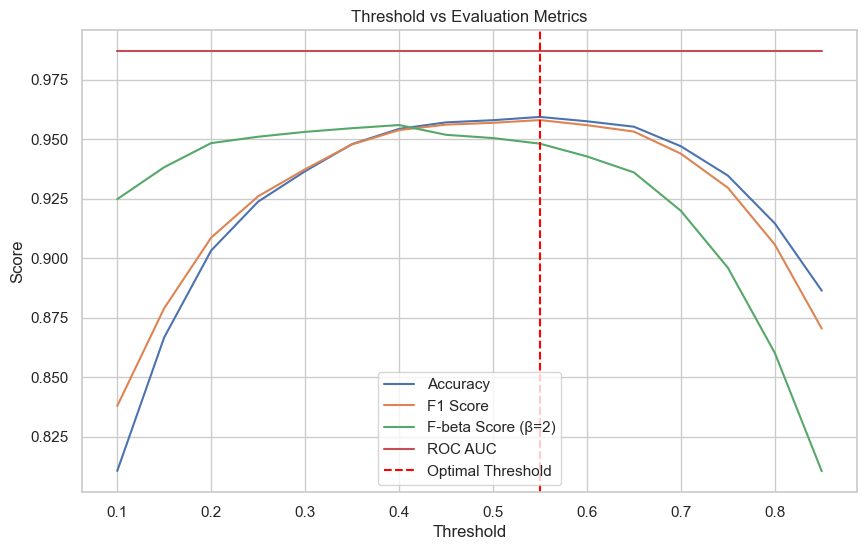

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, fbeta_scores, label='F-beta Score (β=2)')
plt.plot(thresholds, roc_auc_scores, label='ROC AUC')
plt.axvline(optimal_threshold, color='red', linestyle='--', label='Optimal Threshold')
plt.title("Threshold vs Evaluation Metrics")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance Plot

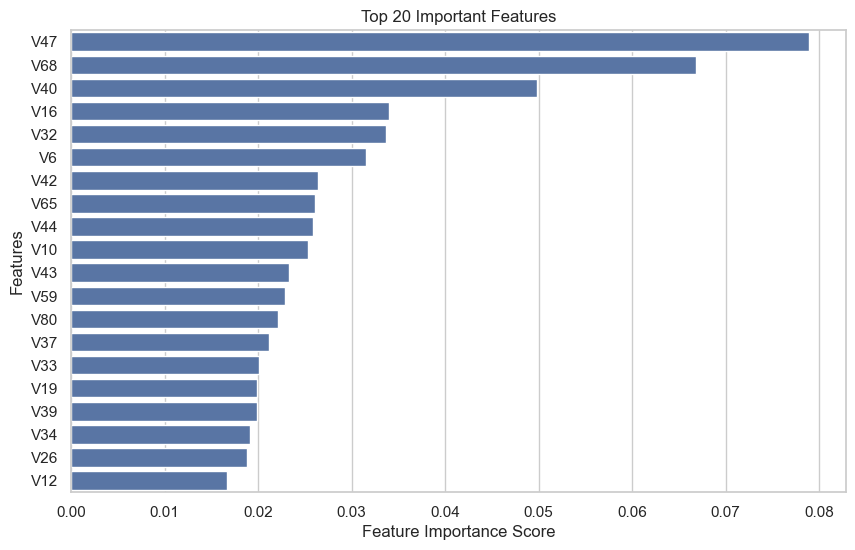

In [36]:
# Get feature importances from best RF model
importances = best_rf_model.feature_importances_
features = [f'V{i}' for i in range(1, 86)]
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Top 20 Important Features")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()